In [90]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures, RobustScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
import xgboost 
from sklearn import set_config
set_config(transform_output="pandas")
pd.set_option('display.max_columns', 500)

In [92]:
from db.database_mysql import engine

df = pd.read_sql_query('''SELECT jp.raw_title, 
        YEAR(jp.date) AS year, 
        MONTH(jp.date) AS month, 
        DAY(jp.date) AS day, 
        im.director, im.date,im.casting, im.distributor, im.genre, jp.country, jp.duration, jp.first_day, jp.first_week, jp.first_weekend, jp.hebdo_rank, 
jp.total_spectator, jp.copies, im.rating_press, im.budget, im.lang, im.award 
FROM films_jp as jp
LEFT JOIN films_imdb im ON im.id_jp = jp.id 
where im.id_jp is not null and im.date = jp.date
order by jp.first_week desc''', engine)

# CREATION DES SCORES

In [ ]:
from modelisation.functions import *

clone = df.copy()
calculate_director_scores(clone)
calculate_distributor_scores(clone)
calculate_actor_scores(clone)
calculate_year_scores(clone)
calculate_country_scores(clone)
print()

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

from modelisation.functions import *

entree_transformer = FunctionTransformer(classify_entrees_year, kw_args={'column' : 'year'})
season_transformer = FunctionTransformer(classify_season,  kw_args={'column' : 'month'})
month_transformer = FunctionTransformer(classify_month_name,  kw_args={'column' : 'month'})
holiday_transformer = FunctionTransformer(is_holiday)
drop_transformer = FunctionTransformer(drop_temp)

pipe_scores = Pipeline([
  ('season_dict' , make_pipeline(season_transformer)),
  ('entree_dict' , make_pipeline(entree_transformer)),
  ('month_dict' , make_pipeline(month_transformer)),
  ('holiday_dict' , make_pipeline(holiday_transformer)),
  #('drop_dict' , make_pipeline(drop_transformer))
])

scores = df.copy()
scores = pipe_scores.fit_transform(scores)
scores.head(1)

# MODELE

In [ ]:
# film = pd.read_sql_query('''SELECT 
#                               YEAR(date) AS year, 
#                               MONTH(date) AS month, 
#                               DAY(date) AS day, 
#                               director, distributor, casting, copies, duration, country
#                             FROM functionalities_filmscrap
#                             LIMIT 1
#                          ''', engine)
# film

In [127]:
from modelisation.converter import *

def convert_entrees_year2(df, column):
    print("convert_entrees_year", df.iloc[0][column])
    scores = load_file("year_scores")

    val = []
    for index, row in df.iterrows():
        # if index == 2448:
        #     print('****')
        #     print(df.iloc[index])
        try:
            found = scores.loc[scores[column] == df.iloc[index][column]]
            val.append(found.iloc[0]["year_combined_score"])
        except Exception:
            val.append(0)

    df["year_combined_score"] = pd.Series(val)

    return df

entree_converter = FunctionTransformer(convert_entrees_year2, kw_args={'column' : 'year'})
country_converter = FunctionTransformer(convert_country, kw_args={'column' : 'country'})
season_converter = FunctionTransformer(classify_season,  kw_args={'column' : 'month'})
month_converter = FunctionTransformer(classify_month_name,  kw_args={'column' : 'month'})
holiday_converter = FunctionTransformer(is_holiday)
director_converter = FunctionTransformer(convert_director, kw_args={'column' : 'director'})
actor_converter = FunctionTransformer(convert_actor, kw_args={'column' : 'casting'})
distributor_converter = FunctionTransformer(convert_distributor, kw_args={'column' : 'distributor'})

def drop_after_converter(df):
  return df.drop(columns=["director",	"casting", "copies",	"distributor",	"country", "month", "day", "year"])

drop_after_converter_pipeline = Pipeline([
  ('drop_after_converter', make_pipeline(FunctionTransformer(drop_after_converter)))
])

def set_ohe(df):
  return pd.get_dummies(df, columns=['season', 'month_name'], dtype='int')

set_ohe_pipeline = Pipeline([
  ('drop_after_converter', make_pipeline(FunctionTransformer(set_ohe)))
])

pipe = Pipeline([
  ('entree_converter' , make_pipeline(entree_converter)),
  ('actor_converter' , make_pipeline(actor_converter)),
  ('season_converter' , make_pipeline(season_converter)),
  ('country_converter' , make_pipeline(country_converter)),
  ('month_converter' , make_pipeline(month_converter)),
  ('holiday_converter' , make_pipeline(holiday_converter)),
  ('director_converter' , make_pipeline(director_converter)),
  ('distributor_converter' , make_pipeline(distributor_converter)),
  ('drop' , make_pipeline(drop_after_converter_pipeline))
])

# t = df.copy()
# t.drop(columns=['raw_title', 'date', 'genre', 'budget', 'total_spectator', 'first_day', 'first_weekend', 'hebdo_rank', 'total_spectator', 'rating_press', 'award', 'lang'], inplace=True)
# p = pipe.fit_transform(t)
# p[p.isna().any(axis=1)]


In [132]:
df_clean = df.copy() 
df_clean.drop(columns=['raw_title', 'date', 'genre', 'budget', 'total_spectator', 'first_day', 'first_weekend', 'hebdo_rank', 'total_spectator', 'rating_press', 'award', 'lang'], inplace=True)

X = df_clean.drop(['first_week'], axis=1)
y = df_clean.first_week

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=0.85, random_state=42)

pipe_transform = make_pipeline(pipe)

p = pipe_transform.transform(X)
#display(p.head())

X_train, X_test, y_train, y_test = train_test_split(p, y, shuffle=True, train_size=0.85, random_state=42)

model = make_pipeline(
  set_ohe_pipeline,
  PolynomialFeatures(),
  RobustScaler(with_centering=False),
  xgboost.XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
)

model.fit(X_train, y_train)

convert_entrees_year 2008
convert_actor
convert_country france
convert_director
convert_distributor


Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('drop_after_converter',
                                  Pipeline(steps=[('functiontransformer',
                                                   FunctionTransformer(func=<function set_ohe at 0x142dbfe20>))]))])),
                ('polynomialfeatures', PolynomialFeatures()),
                ('robustscaler', RobustScaler(with_centering=False)),
                ('xgbregressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_...
                              eval_metric=None, feature_types=None, gamma=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=7, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=1000, n_jobs=None,
                              num_parallel_tree=None, ...))])

Performance du modèle :
R2 Score: 0.3804
MAE: 189769.68
RMSE: 307636.45


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

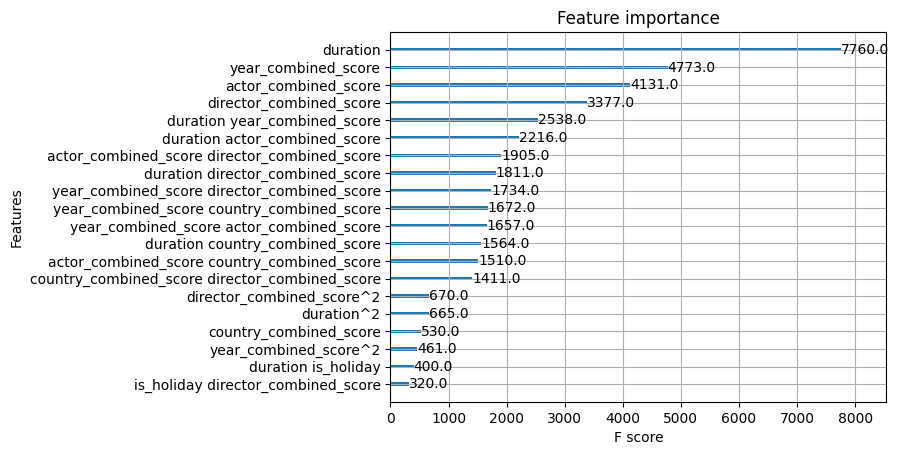

In [133]:
y_pred = model.predict(X_test)

r2_cleaned = r2_score(y_test, y_pred)
mse_cleaned = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse_cleaned = np.sqrt(mse_cleaned)

print("Performance du modèle :")
# print(model.best_params_)
print(f"R2 Score: {r2_cleaned:.4f}")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse_cleaned:.2f}")

xgboost.plot_importance(model[-1], max_num_features=20)

In [102]:
display(p.head(2))
p[p.isna().any(axis=1)]

,year,month,day,director,casting,distributor,country,duration,copies,season,year_combined_score,month_name,is_holiday,director_combined_score,actor_combined_score,distributor_combined_score
0,2008,2,27,"""dany boon""","[""kad merad"", ""dany boon"", ""zoe felix""]","[""pathe renn productions"", ""hirsch"", ""les prod...",france,6360,793,winter,0.83092,february,0,0.461777,0.557049,0
1,2006,2,1,"""patrice leconte""","[""josiane balasko"", ""michel blanc"", ""marieanne...","[""les films christian fechner"", ""tf1 films pro...",france,5820,950,winter,0.83092,february,0,0.248820,0.529809,0


,year,month,day,director,casting,distributor,country,duration,copies,season,year_combined_score,month_name,is_holiday,director_combined_score,actor_combined_score,distributor_combined_score
